# Bírósági Határozatok - Exploratív Adatanalízis (EDA)

Ez a notebook a Blob Storage-ban tárolt, megtisztított bírósági határozatok (`cleaned_documents.parquet`) adatait elemzi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from dotenv import load_dotenv
import os
import sys
from azure.storage.blob import BlobServiceClient
import io

sys.path.insert(0, os.path.abspath('..'))
load_dotenv()

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONNECTION_STRING")
AZURE_CONTAINER_NAME = "courtrankrl"
BLOB_PATH = "processed/cleaned_documents.parquet"

# Adatok letöltése és beolvasása a Blob Storage-ból
print(f"Adatok letöltése és beolvasása innen: {AZURE_CONTAINER_NAME}/{BLOB_PATH}...")
try:
    blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
    blob_client = blob_service_client.get_blob_client(container=AZURE_CONTAINER_NAME, blob=BLOB_PATH)
    
    stream = io.BytesIO()
    blob_client.download_blob().readinto(stream)
    stream.seek(0)
    
    df = pd.read_parquet(stream)
    print(f"{len(df)} dokumentum betöltve sikeresen.")
    
except Exception as e:
    print(f"Hiba történt a Blob Storage-ból való letöltés vagy beolvasás során: {e}")
    df = None # Hiba esetén df legyen None

# Matplotlib beállítások
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

Adatok letöltése és beolvasása innen: courtrankrl/processed/cleaned_documents.parquet...
216587 dokumentum betöltve sikeresen.


## 1. Adatok Betöltése

In [2]:
# Az adatkeret előkészítése: felesleges oszlopok eltávolítása és átnevezések
if 'df' in locals() and df is not None:
    print(f"Eredeti oszlopok: {df.columns.tolist()}")
    
    # Oszlopok eldobása
    columns_to_drop = ['Rezume', 'IndexelesIdeje', 'IndexId']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df.drop(columns=existing_columns_to_drop, inplace=True)
        print(f"Eltávolított oszlopok: {existing_columns_to_drop}")
    else:
        print("A megadott oszlopok ('Rezume', 'IndexelesIdeje', 'IndexId') egyike sem található.")

    # Oszlopok átnevezése
    rename_mapping = {
        'AllKapcsolodoUgyszam': 'Kapcsolódó Ügyszám',
        'AllKapcsolodoBirosag': 'Kapcsolódó Bíróság'
    }
    # Csak a létező oszlopokat nevezzük át
    existing_rename_mapping = {k: v for k, v in rename_mapping.items() if k in df.columns}
    if existing_rename_mapping:
        df.rename(columns=existing_rename_mapping, inplace=True)
        print(f"Átnevezett oszlopok: {existing_rename_mapping}")
    else:
        print("Az átnevezendő oszlopok ('AllKapcsolodoUgyszam', 'AllKapcsolodoBirosag') egyike sem található.")

    print(f"\nMegmaradt oszlopok: {df.columns.tolist()}")
else:
    print("Hiba: 'df' adatkeret nem létezik vagy üres. Az adatok betöltése valószínűleg sikertelen volt.")

Eredeti oszlopok: ['doc_id', 'text', 'birosag', 'JogTerulet', 'Azonosito', 'MeghozoBirosag', 'EgyediAzonosito', 'HatarozatEve', 'AllKapcsolodoUgyszam', 'AllKapcsolodoBirosag', 'KapcsolodoHatarozatok', 'Jogszabalyhelyek', 'Kollegium', 'Rezume', 'IndexelesIdeje', 'IndexId']
Eltávolított oszlopok: ['Rezume', 'IndexelesIdeje', 'IndexId']
Átnevezett oszlopok: {'AllKapcsolodoUgyszam': 'Kapcsolódó Ügyszám', 'AllKapcsolodoBirosag': 'Kapcsolódó Bíróság'}

Megmaradt oszlopok: ['doc_id', 'text', 'birosag', 'JogTerulet', 'Azonosito', 'MeghozoBirosag', 'EgyediAzonosito', 'HatarozatEve', 'Kapcsolódó Ügyszám', 'Kapcsolódó Bíróság', 'KapcsolodoHatarozatok', 'Jogszabalyhelyek', 'Kollegium']


## 2. Alapvető Információk és Statisztikák

In [3]:
if 'df' in locals():
    print("Adatkeret mérete (sorok, oszlopok):", df.shape)
    print("\nElső 5 sor:")
    display(df.head())
    print("\nAdattípusok és nem-null értékek:")
    df.info()
    print("\nLeíró statisztikák (numerikus oszlopok):")
    display(df.describe())
    print("\nLeíró statisztikák (kategorikus és egyéb oszlopok):")
    display(df.describe(include=['object', 'boolean']))

Adatkeret mérete (sorok, oszlopok): (216587, 13)

Első 5 sor:


,doc_id,text,birosag,JogTerulet,Azonosito,MeghozoBirosag,EgyediAzonosito,HatarozatEve,Kapcsolódó Ügyszám,Kapcsolódó Bíróság,KapcsolodoHatarozatok,Jogszabalyhelyek,Kollegium
0,G.21002/2009/17,A GYÖNGYÖSI VÁROSI BIRÓSÁG 3.G.21.002/2009/17....,Gyöngyösi Járásbíróság,gazdasági jog,G.21002/2009/17,Gyöngyösi Járásbíróság,10/3-GJ-2010-1,2010.0,"[""Pfv.21145/2011/5"", ""Gf.25804/2010/4""]","[""Kúria"", ""Egri Törvényszék""]","[{""KapcsolodoUgyszam"": ""Pfv.21145/2011/5"", ""Ka...",1952. évi III. törvény a polgári perrendtartás...,gazdasági
1,G.20992/2012/31,A GYÖNGYÖSI JÁRÁSBÍRÓSÁG 7.G.20.992/2012/31. s...,Gyöngyösi Járásbíróság,gazdasági jog,G.20992/2012/31,Gyöngyösi Járásbíróság,10/3-GJ-2013-1,2013.0,"[""Gf.20041/2014/9"", ""Pfv.21605/2014/5""]","[""Egri Törvényszék"", ""Kúria""]","[{""KapcsolodoUgyszam"": ""Gf.20041/2014/9"", ""Kap...",1952. évi III. törvény a polgári perrendtartás...,polgári
2,G.20134/2005/45,A GYÖNGYÖSI VÁROSI BÍRÓSÁG 3.G.20.134/2005/45....,Gyöngyösi Járásbíróság,gazdasági jog,G.20134/2005/45,Gyöngyösi Járásbíróság,10/3-GJ-2006-1,2006.0,"[""Pfv.20181/2008/3"", ""Pf.25471/2007/4""]","[""Kúria"", ""Egri Törvényszék""]","[{""KapcsolodoUgyszam"": ""Pfv.20181/2008/3"", ""Ka...",1952. évi III. törvény a polgári perrendtartás...,polgári; gazdasági
3,G.20450/2013/21,GYÖNGYÖSI JÁRÁSBÍRÓSÁG 3.G.20.450/2013/21. szá...,Gyöngyösi Járásbíróság,gazdasági jog,G.20450/2013/21,Gyöngyösi Járásbíróság,10/3-GJ-2014-1,2014.0,"[""Gf.20264/2014/7"", ""Pfv.20827/2015/7""]","[""Egri Törvényszék"", ""Kúria""]","[{""KapcsolodoUgyszam"": ""Gf.20264/2014/7"", ""Kap...",1952. évi III. törvény a polgári perrendtartás...,polgári; gazdasági
4,P.20292/2013/21,A GYÖNGYÖSI JÁRÁSBÍRÓSÁG 1.P.20.292/2013/21. s...,Gyöngyösi Járásbíróság,polgári jog,P.20292/2013/21,Gyöngyösi Járásbíróság,10/3-PJ-2013-4,2013.0,"[""Pf.20036/2014/6"", ""Pfv.21483/2014/4""]","[""Egri Törvényszék"", ""Kúria""]","[{""KapcsolodoUgyszam"": ""Pf.20036/2014/6"", ""Kap...",1952. évi III. törvény a polgári perrendtartás...,polgári



Adattípusok és nem-null értékek:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216587 entries, 0 to 216586
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   doc_id                 216587 non-null  object 
 1   text                   216587 non-null  object 
 2   birosag                216587 non-null  object 
 3   JogTerulet             216304 non-null  object 
 4   Azonosito              216305 non-null  object 
 5   MeghozoBirosag         216305 non-null  object 
 6   EgyediAzonosito        216305 non-null  object 
 7   HatarozatEve           216305 non-null  float64
 8   Kapcsolódó Ügyszám     176998 non-null  object 
 9   Kapcsolódó Bíróság     176998 non-null  object 
 10  KapcsolodoHatarozatok  216305 non-null  object 
 11  Jogszabalyhelyek       216305 non-null  object 
 12  Kollegium              216305 non-null  object 
dtypes: float64(1), object(12)
memory usage: 21.5+ MB

Leíró

,HatarozatEve
count,216305.000000
mean,2014.867936
std,5.181719
min,1989.000000
25%,2010.000000
50%,2015.000000
75%,2019.000000
max,2025.000000



Leíró statisztikák (kategorikus és egyéb oszlopok):


,doc_id,text,birosag,JogTerulet,Azonosito,MeghozoBirosag,EgyediAzonosito,Kapcsolódó Ügyszám,Kapcsolódó Bíróság,KapcsolodoHatarozatok,Jogszabalyhelyek,Kollegium
count,216587,216587,216587,216304,216305,216305,216305,176998,176998,216305,216305,216305
unique,213364,216572,186,8,213082,159,214051,174395,1388,175481,215620,33
top,Pf.20009/2024/4,A Kúria mint felülvizsgálati bíróság ítélete A...,Kúria,polgári jog,Pf.20200/2017/6,Kúria,K-KJ-2021-75,"[""Bf.100/2011/4""]","[""Fővárosi Törvényszék""]",null,,polgári
freq,4,2,49438,84832,4,49438,2,4,22237,39307,47,88499


## 3. Hiányzó Értékek Elemzése

Hiányzó értékek oszloponként:


,Darabszám,Százalék
Kapcsolódó Ügyszám,39589,18.278567
Kapcsolódó Bíróság,39589,18.278567
JogTerulet,283,0.130663
Azonosito,282,0.130202
MeghozoBirosag,282,0.130202
EgyediAzonosito,282,0.130202
HatarozatEve,282,0.130202
KapcsolodoHatarozatok,282,0.130202
Jogszabalyhelyek,282,0.130202
Kollegium,282,0.130202


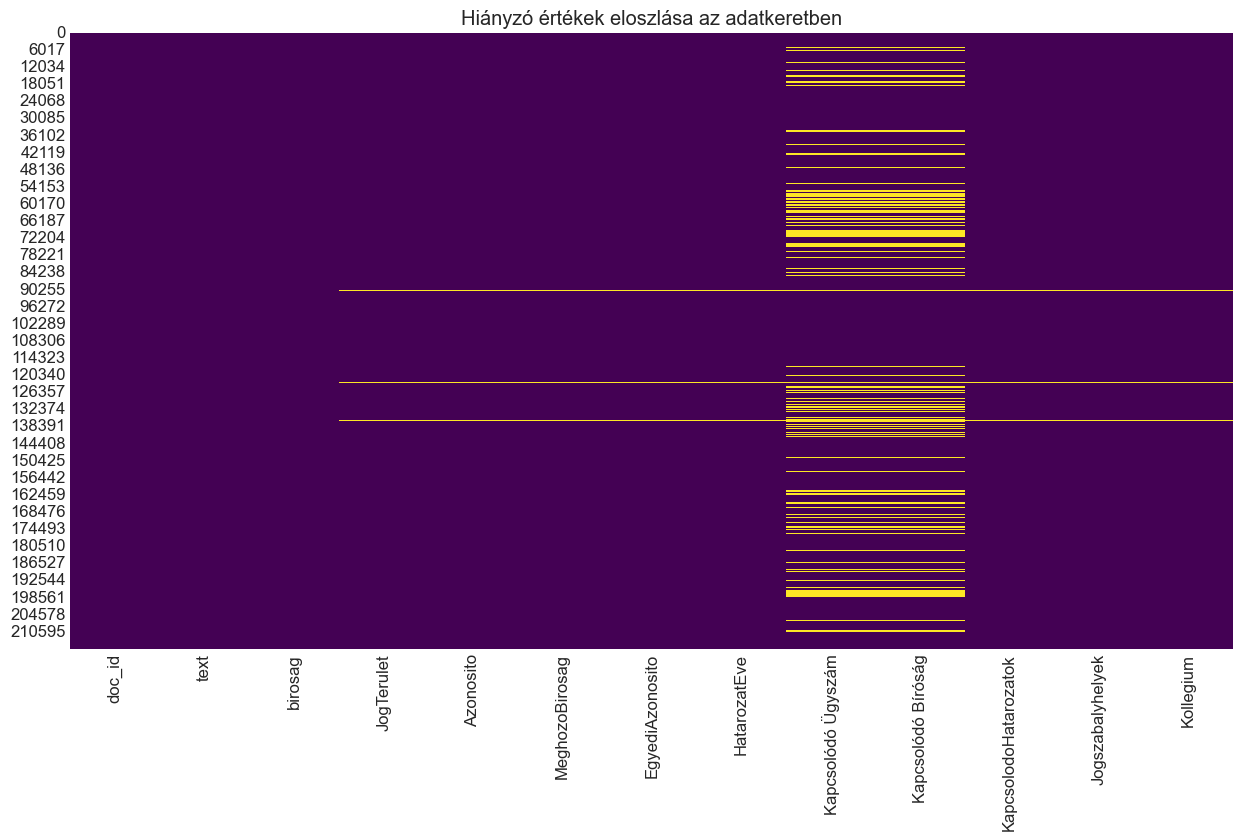

In [4]:
if 'df' in locals():
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Darabszám': missing_values, 'Százalék': missing_percent})
    missing_df = missing_df[missing_df['Darabszám'] > 0].sort_values(by='Százalék', ascending=False)

    print("Hiányzó értékek oszloponként:")
    display(missing_df)

    # Hiányzó értékek vizualizációja (heatmap)
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Hiányzó értékek eloszlása az adatkeretben')
    plt.show()

## 4. Szövegelemzés

Szöveghossz statisztikák (karakterek):


count    2.165870e+05
mean     2.616497e+04
std      3.348226e+04
min      1.540000e+02
25%      1.287700e+04
50%      1.935400e+04
75%      2.984000e+04
max      1.557475e+06
Name: text_length, dtype: float64


Az adatok 99%-a 125853 karakternél rövidebb szöveget tartalmaz.
A hisztogram csak ezeket az adatokat mutatja ( 214421 db ).


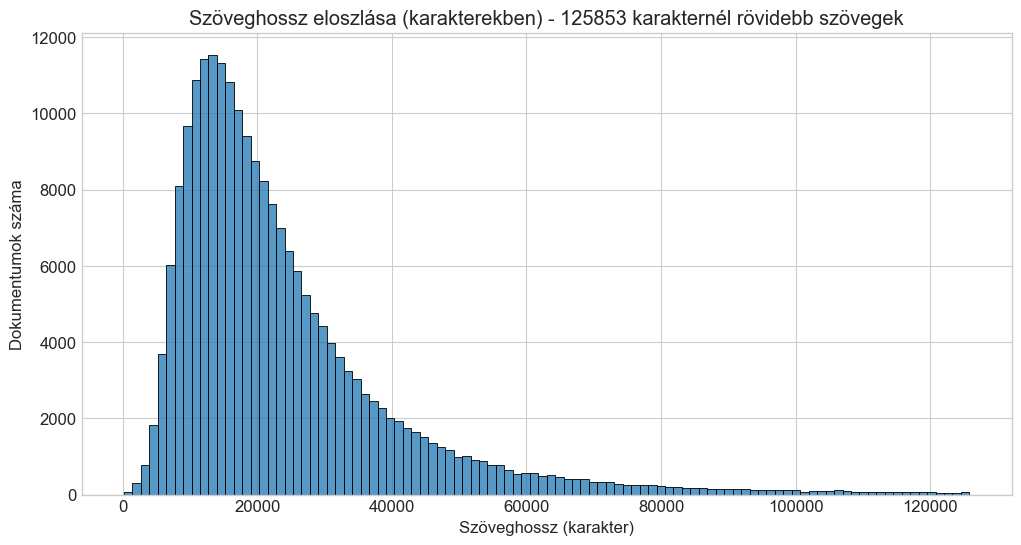


0 db 50 karakternél rövidebb dokumentum található.

0 db üres szövegű dokumentum található.


In [5]:
if 'df' in locals() and 'text' in df.columns:
    # Szöveghossz számítása (karakterekben)
    df['text_length'] = df['text'].fillna('').astype(str).apply(len)

    print("Szöveghossz statisztikák (karakterek):")
    display(df['text_length'].describe())

    # Kiugró értékek szűrése a jobb vizualizáció érdekében
    # Például a 99. percentilis alatti értékek megjelenítése
    quantile_99 = df['text_length'].quantile(0.99)
    df_filtered_length = df[df['text_length'] < quantile_99]
    print(f"\nAz adatok 99%-a {quantile_99:.0f} karakternél rövidebb szöveget tartalmaz.")
    print(f"A hisztogram csak ezeket az adatokat mutatja ( {len(df_filtered_length)} db ).")

    # Szöveghossz eloszlás vizualizáció (szűrt adatokon)
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_filtered_length, x='text_length', bins=100, kde=False)
    plt.title(f'Szöveghossz eloszlása (karakterekben) - {quantile_99:.0f} karakternél rövidebb szövegek')
    plt.xlabel('Szöveghossz (karakter)')
    plt.ylabel('Dokumentumok száma')
    plt.grid(True)
    plt.show()

    # Rövid szövegek vizsgálata
    short_text_threshold = 50
    short_texts = df[df['text_length'] < short_text_threshold]
    print(f"\n{len(short_texts)} db {short_text_threshold} karakternél rövidebb dokumentum található.")
    if not short_texts.empty:
        print(f"Példák rövid szövegekre (max 10):")
        display(short_texts[['doc_id', 'text', 'text_length']].head(10))

    # Üres szövegek vizsgálata
    empty_texts = df[df['text_length'] == 0]
    print(f"\n{len(empty_texts)} db üres szövegű dokumentum található.")
    if not empty_texts.empty:
        print(f"Példák üres szövegekre (max 10):")
        display(empty_texts[['doc_id', 'text_length']].head(10))

## 5. Kategorikus Változók Elemzése


'birosag' egyedi értékeinek száma: 129
Leggyakoribb 30 érték:


birosag
Kúria                                                   49438
Fővárosi Törvényszék                                    34416
Fővárosi Ítélőtábla                                     31997
Budapest Környéki Törvényszék                            8835
Debreceni Ítélőtábla                                     7130
Győri Ítélőtábla                                         6204
Szegedi Ítélőtábla                                       5787
Debreceni Törvényszék                                    5624
Szegedi Törvényszék                                      5083
Pécsi Ítélőtábla                                         4461
Miskolci Törvényszék                                     4358
Fővárosi Közigazgatási és Munkaügyi Bíróság              3701
Győri Törvényszék                                        3412
Veszprémi Törvényszék                                    3035
Pécsi Törvényszék                                        2827
Kecskeméti Törvényszék                                   2677


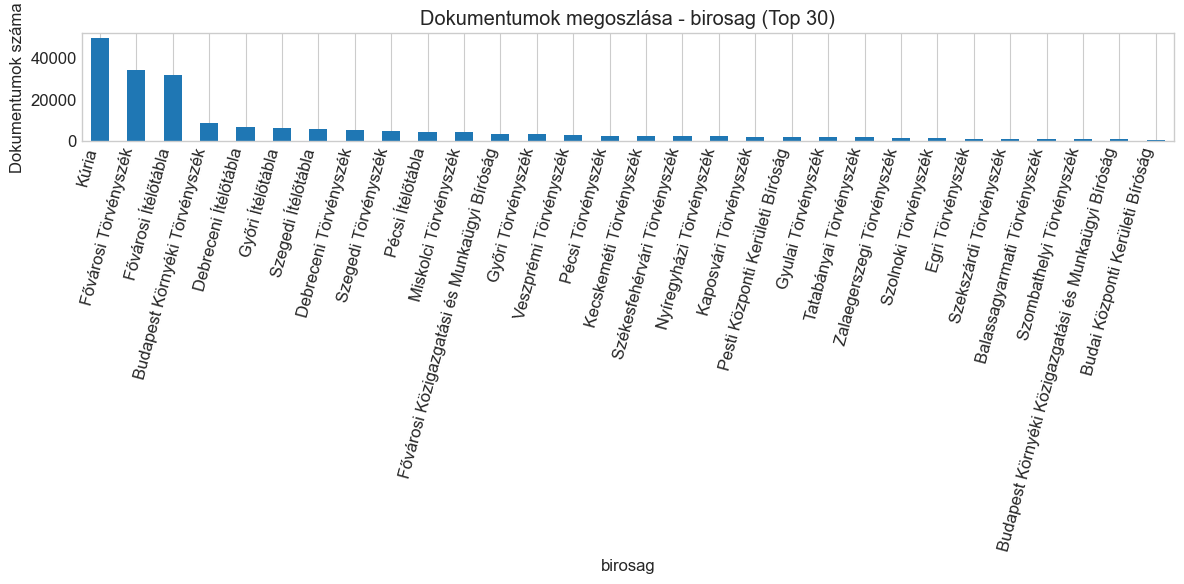


'JogTerulet' egyedi értékeinek száma: 8
Leggyakoribb 20 érték:


JogTerulet
polgári jog                  84832
közigazgatási jog            50153
büntetőjog                   34579
gazdasági jog                25300
munkaügy                     18556
katonai büntetőjog            2851
szabálysértési jog              27
büntetés-végrehajtási ügy        6
Name: count, dtype: int64

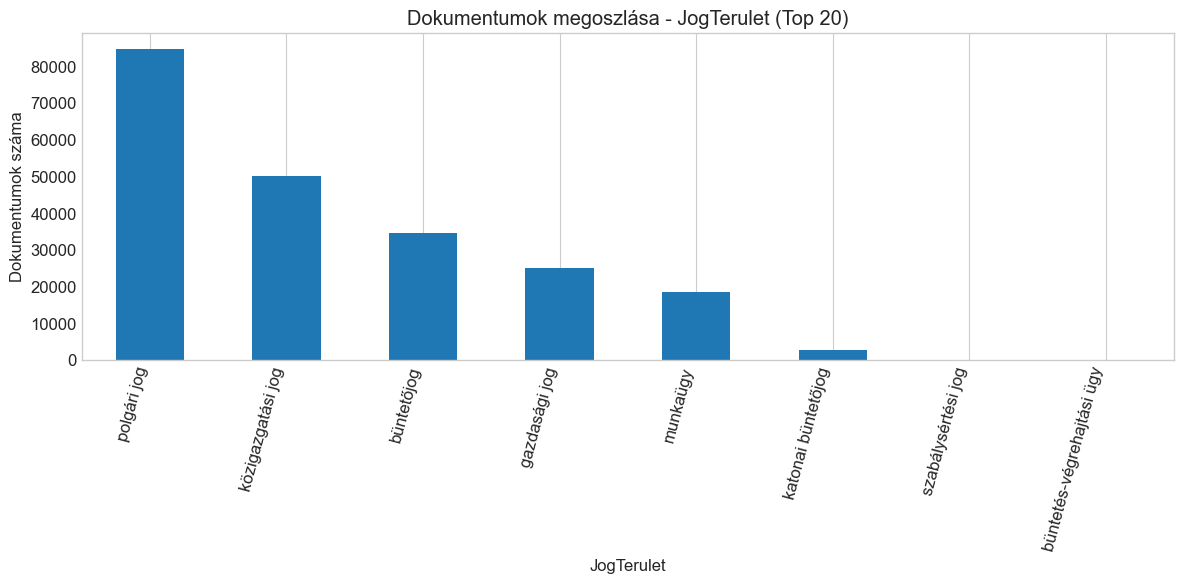


Érvényes 'HatarozatEve' értékek száma (2005 óta): 216116
Érvénytelen vagy hiányzó 'HatarozatEve' értékek száma: 471


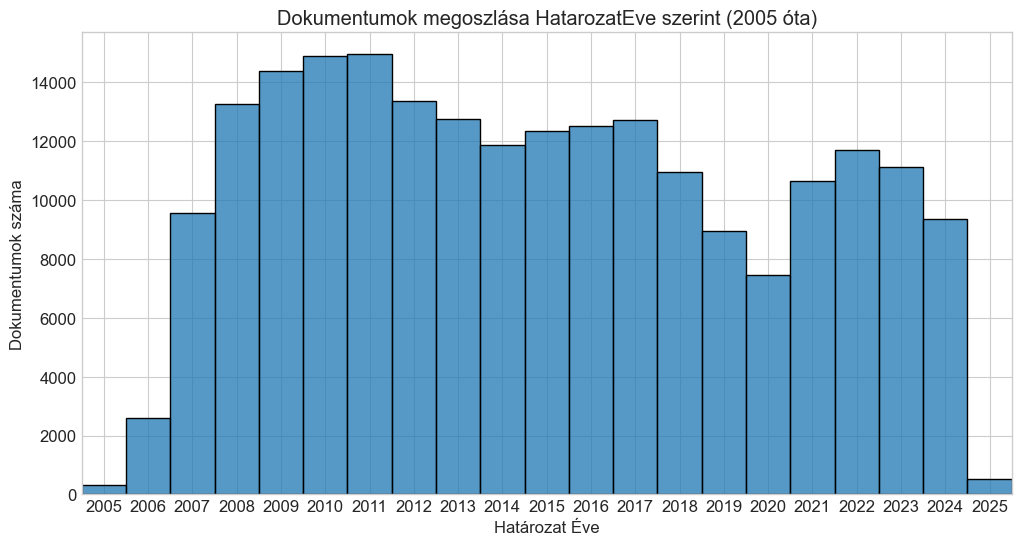

In [6]:
def plot_top_categories(df, column_name, top_n=20):
    """Segédfüggvény a leggyakoribb kategóriák megjelenítésére."""
    if column_name not in df.columns:
        print(f"Hiba: '{column_name}' oszlop nem található.")
        return

    counts = df[column_name].value_counts()
    print(f"\n'{column_name}' egyedi értékeinek száma: {counts.nunique()}")
    print(f"Leggyakoribb {top_n} érték:")
    display(counts.head(top_n))

    plt.figure(figsize=(12, 6))
    counts.head(top_n).plot(kind='bar')
    plt.title(f'Dokumentumok megoszlása - {column_name} (Top {top_n})')
    plt.xlabel(column_name)
    plt.ylabel('Dokumentumok száma')
    plt.xticks(rotation=75, ha='right')
    plt.grid(axis='y')
    plt.tight_layout() # Ensure labels fit
    plt.show()

if 'df' in locals():
    # Bíróság elemzése
    plot_top_categories(df, 'birosag', top_n=30)

    # Jogterület elemzése
    # Megjegyzés: A JogTerulet lehet komplex (pl. lista). A preprocess script stringgé alakítja.
    # Ha mégsem, akkor itt további tisztításra lehet szükség.
    plot_top_categories(df, 'JogTerulet', top_n=20)

    # HatarozatEve elemzése
    if 'HatarozatEve' in df.columns:
        # Érvényes évszámok szűrése (pl. 2005-től napjainkig) és integer típussá alakítás
        # Use Int64 to handle potential NaNs while keeping integer type
        df['HatarozatEve_num'] = pd.to_numeric(df['HatarozatEve'], errors='coerce').astype('Int64')
        valid_years_mask = (df['HatarozatEve_num'] >= 2005) & (df['HatarozatEve_num'] <= pd.Timestamp.now().year)
        valid_years = df.loc[valid_years_mask, 'HatarozatEve_num']

        print(f"\nÉrvényes 'HatarozatEve' értékek száma (2005 óta): {len(valid_years)}")
        print(f"Érvénytelen vagy hiányzó 'HatarozatEve' értékek száma: {len(df) - len(valid_years)}")

        if not valid_years.empty:
            plt.figure(figsize=(12, 6))
            # Use discrete=True for integer years to center bars on ticks
            min_year = valid_years.min()
            max_year = valid_years.max()
            # Let histplot handle bins for discrete data
            sns.histplot(x=valid_years, kde=False, discrete=True)
            plt.title('Dokumentumok megoszlása HatarozatEve szerint (2005 óta)')
            plt.xlabel('Határozat Éve')
            plt.ylabel('Dokumentumok száma')
            # Ensure ticks are placed at integer years
            tick_step = max(1, (max_year - min_year) // 20) # Adjust step for readability
            plt.xticks(ticks=range(min_year, max_year + 1, tick_step), rotation=0) # Set rotation to 0 for clarity if possible
            plt.xlim(min_year - 0.5, max_year + 0.5) # Keep slight padding
            plt.grid(True)
            plt.show()
        else:
            print("\n'HatarozatEve' oszlop nem található vagy nincsenek érvényes évszámok 2005 óta.")

## 5.1. Bíróság és Jogterület Kapcsolata


Bíróság és Jogterület kapcsolata:


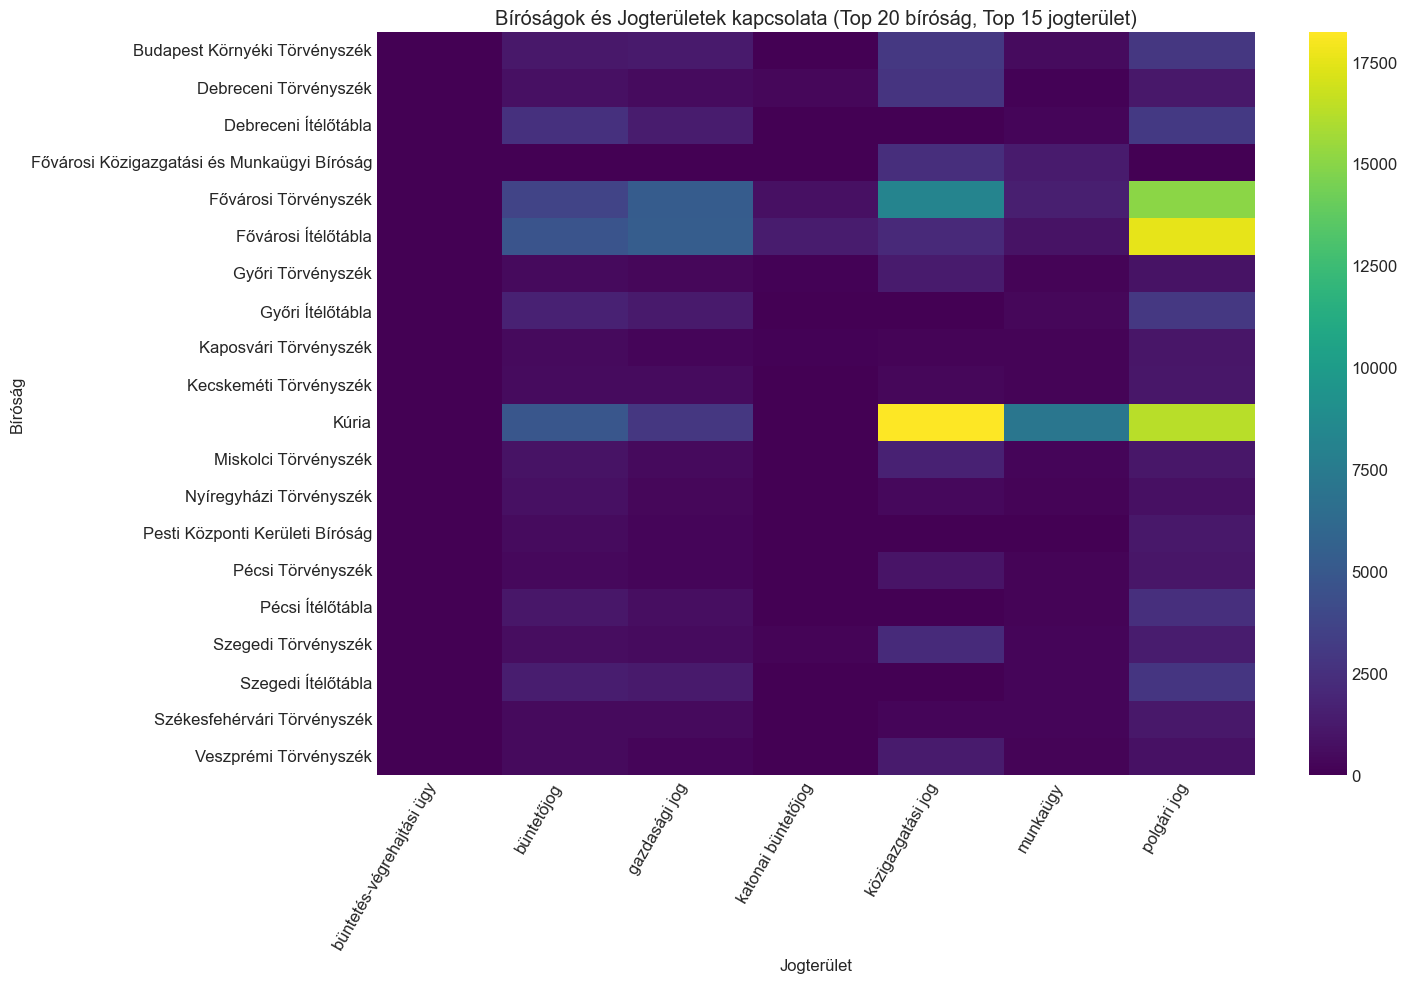

In [7]:
if 'df' in locals() and 'birosag' in df.columns and 'JogTerulet' in df.columns:
    print("\nBíróság és Jogterület kapcsolata:")
    top_n_birosag = 20
    top_m_jogterulet = 15
    top_birosagok = df['birosag'].value_counts().nlargest(top_n_birosag).index
    top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_m_jogterulet).index
    df_filtered = df[df['birosag'].isin(top_birosagok) & df['JogTerulet'].isin(top_jogteruletek)]
    if not df_filtered.empty:
        crosstab_bj = pd.crosstab(df_filtered['birosag'], df_filtered['JogTerulet'])
        plt.figure(figsize=(15, 10))
        sns.heatmap(crosstab_bj, cmap="viridis", annot=False, fmt="d")
        plt.title(f'Bíróságok és Jogterületek kapcsolata (Top {top_n_birosag} bíróság, Top {top_m_jogterulet} jogterület)')
        plt.xlabel('Jogterület')
        plt.ylabel('Bíróság')
        plt.xticks(rotation=60, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Nem található elég adat a szűrt bíróságokhoz és jogterületekhez a kereszttábla elkészítéséhez.")

## 5.2. Szöveghossz és Kategóriák

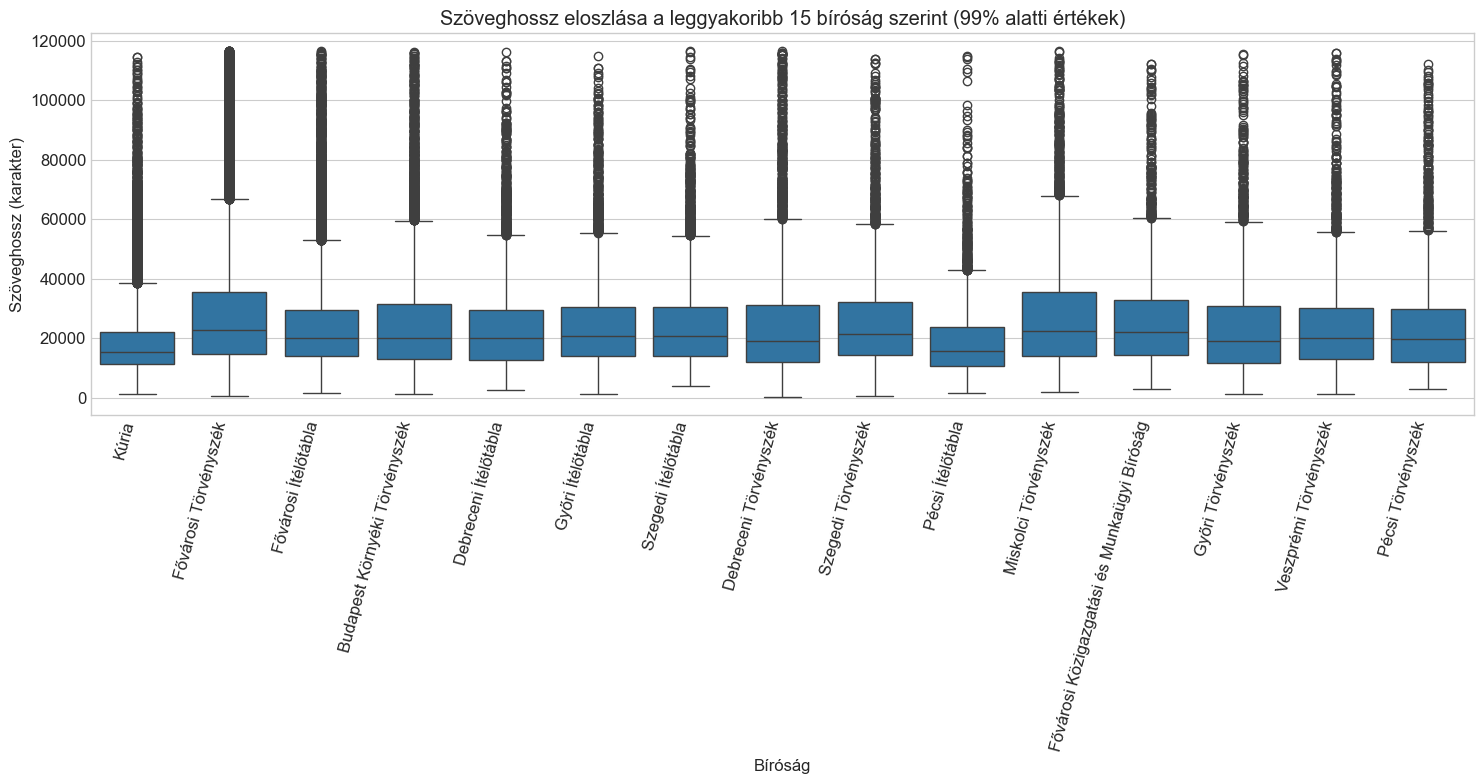

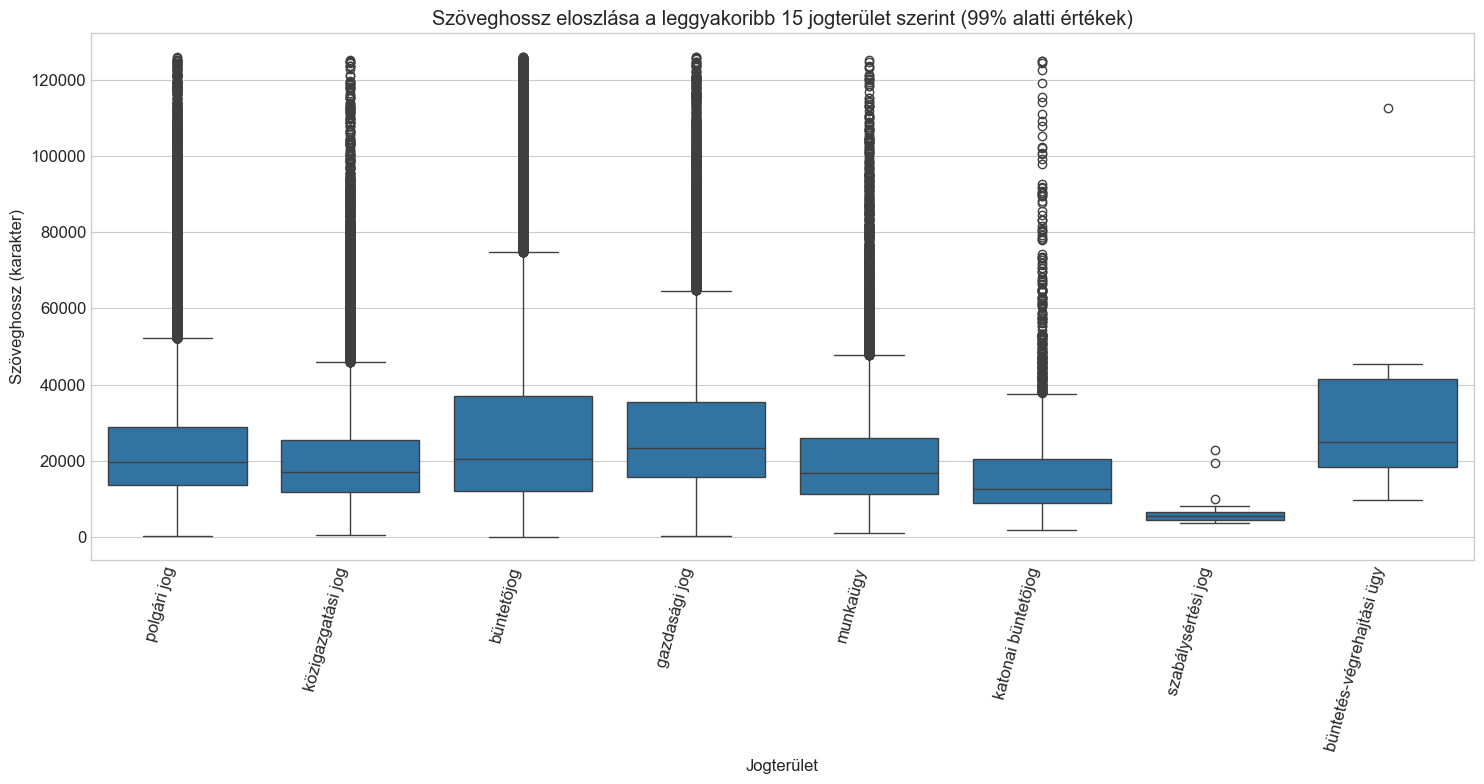

In [8]:
if 'df' in locals() and 'text_length' in df.columns:
    top_n = 15
    if 'birosag' in df.columns:
        top_birosagok = df['birosag'].value_counts().nlargest(top_n).index
        df_filtered_birosag = df[df['birosag'].isin(top_birosagok)]
        quantile_99 = df_filtered_birosag['text_length'].quantile(0.99)
        df_plot_birosag = df_filtered_birosag[df_filtered_birosag['text_length'] < quantile_99]
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=df_plot_birosag, x='birosag', y='text_length', order=top_birosagok)
        plt.title(f'Szöveghossz eloszlása a leggyakoribb {top_n} bíróság szerint (99% alatti értékek)')
        plt.xlabel('Bíróság')
        plt.ylabel('Szöveghossz (karakter)')
        plt.xticks(rotation=75, ha='right')
        plt.tight_layout()
        plt.show()
    if 'JogTerulet' in df.columns:
        top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_n).index
        df_filtered_jogterulet = df[df['JogTerulet'].isin(top_jogteruletek)]
        quantile_99_jt = df_filtered_jogterulet['text_length'].quantile(0.99)
        df_plot_jogterulet = df_filtered_jogterulet[df_filtered_jogterulet['text_length'] < quantile_99_jt]
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=df_plot_jogterulet, x='JogTerulet', y='text_length', order=top_jogteruletek)
        plt.title(f'Szöveghossz eloszlása a leggyakoribb {top_n} jogterület szerint (99% alatti értékek)')
        plt.xlabel('Jogterület')
        plt.ylabel('Szöveghossz (karakter)')
        plt.xticks(rotation=75, ha='right')
        plt.tight_layout()
        plt.show()

## 5.3. Időbeli Trendek


Jogterületek gyakoriságának változása az évek során:


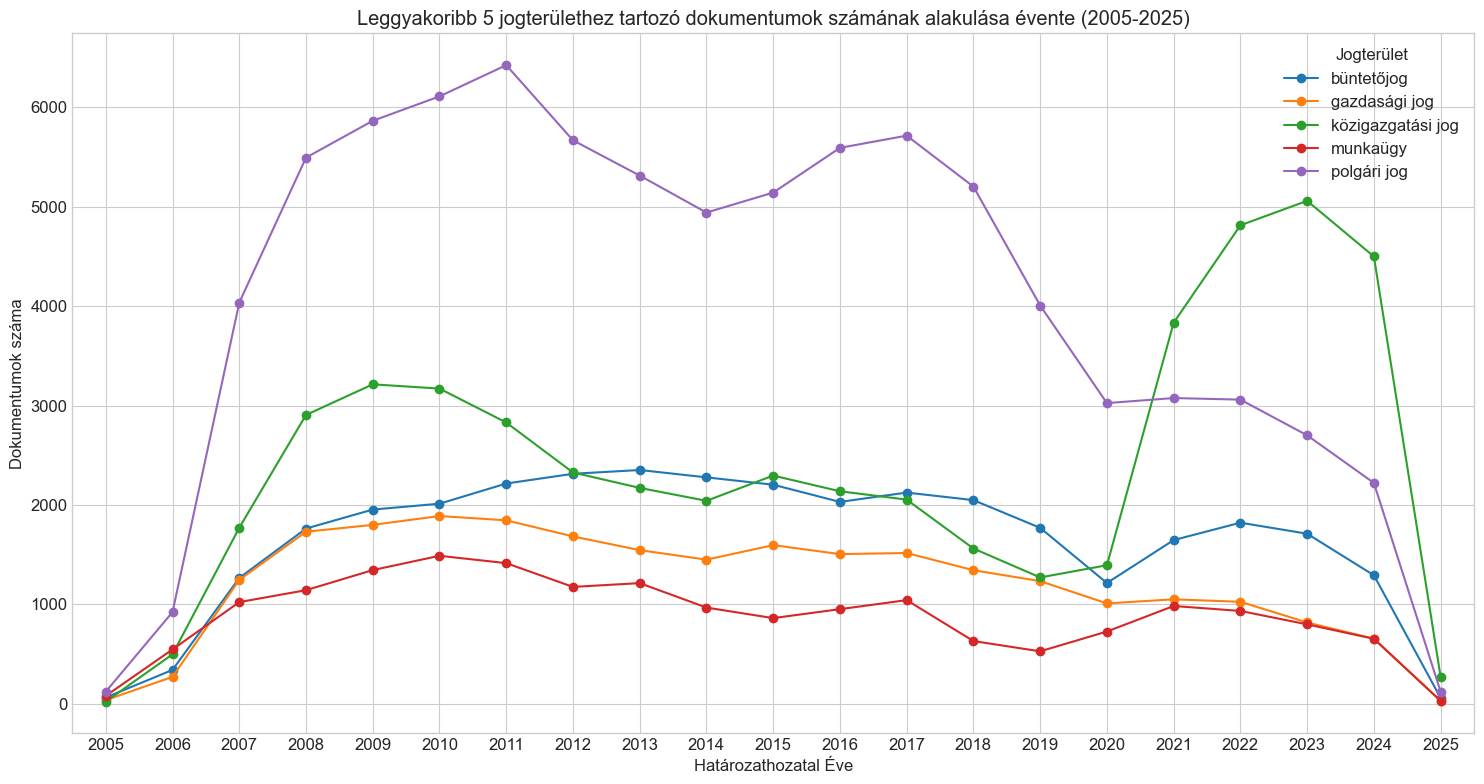

In [9]:
if 'df' in locals() and 'HatarozatEve_num' in df.columns and 'JogTerulet' in df.columns:
    print("\nJogterületek gyakoriságának változása az évek során:")
    # Ensure HatarozatEve_num is Int64 before filtering
    if not pd.api.types.is_integer_dtype(df['HatarozatEve_num']):
         df['HatarozatEve_num'] = pd.to_numeric(df['HatarozatEve'], errors='coerce').astype('Int64')

    min_analysis_year = 2005
    current_year = pd.Timestamp.now().year
    valid_years_mask = (df['HatarozatEve_num'] >= min_analysis_year) & (df['HatarozatEve_num'] <= current_year)
    top_m_jogterulet = 5
    top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_m_jogterulet).index
    df_filtered_time = df[valid_years_mask & df['JogTerulet'].isin(top_jogteruletek)].copy()

    if not df_filtered_time.empty:
        trends = df_filtered_time.groupby(['HatarozatEve_num', 'JogTerulet']).size().unstack(fill_value=0)
        plt.figure(figsize=(15, 8))
        trends.plot(kind='line', marker='o', ax=plt.gca()) # Added marker for clarity
        plt.title(f'Leggyakoribb {top_m_jogterulet} jogterülethez tartozó dokumentumok számának alakulása évente ({min_analysis_year}-{current_year})')
        plt.xlabel('Határozathozatal Éve')
        plt.ylabel('Dokumentumok száma')
        plt.xticks(range(min_analysis_year, current_year + 1, max(1, (current_year - min_analysis_year) // 15))) # Adjust tick frequency
        plt.xlim(min_analysis_year - 0.5, current_year + 0.5) # Adjust xlim slightly
        plt.legend(title='Jogterület')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Nem található elég adat a top {top_m_jogterulet} jogterület időbeli trendjének vizsgálatához {min_analysis_year} óta.")

## 6. Azonosítók Elemzése

In [10]:
if 'df' in locals():
    for id_col in ['doc_id', 'Azonosito', 'EgyediAzonosito']:
        if id_col in df.columns:
            print(f"\n'{id_col}' elemzése:")
            uniqueness = df[id_col].nunique()
            total_rows = len(df)
            duplicates = total_rows - uniqueness
            print(f"  Összes sor: {total_rows}")
            print(f"  Egyedi értékek: {uniqueness}")
            print(f"  Duplikált értékek (vagy hiányzó): {duplicates}")
            if duplicates > 0:
                duplicated_ids = df[df.duplicated(subset=[id_col], keep=False)][id_col].value_counts()
                print(f"  Leggyakoribb duplikált/hiányzó '{id_col}' értékek:")
                display(duplicated_ids[duplicated_ids > 1].head())
        else:
            print(f"\n'{id_col}' oszlop nem található.")


'doc_id' elemzése:
  Összes sor: 216587
  Egyedi értékek: 213364
  Duplikált értékek (vagy hiányzó): 3223
  Leggyakoribb duplikált/hiányzó 'doc_id' értékek:


doc_id
Pf.20154/2018/4    4
Pf.20009/2024/4    4
Pf.20075/2017/4    4
Pf.20200/2017/6    4
Pf.20836/2014/3    3
Name: count, dtype: int64


'Azonosito' elemzése:
  Összes sor: 216587
  Egyedi értékek: 213082
  Duplikált értékek (vagy hiányzó): 3505
  Leggyakoribb duplikált/hiányzó 'Azonosito' értékek:


Azonosito
Pf.20154/2018/4    4
Pf.20009/2024/4    4
Pf.20075/2017/4    4
Pf.20200/2017/6    4
Pf.20836/2014/3    3
Name: count, dtype: int64


'EgyediAzonosito' elemzése:
  Összes sor: 216587
  Egyedi értékek: 214051
  Duplikált értékek (vagy hiányzó): 2536
  Leggyakoribb duplikált/hiányzó 'EgyediAzonosito' értékek:


EgyediAzonosito
10/3-BJ-2017-1    2
K-PJ-2021-17      2
K-PJ-2021-29      2
K-PJ-2020-5       2
K-PJ-2021-50      2
Name: count, dtype: int64

## 7. Kapcsolódó Határozatok Elemzése


'KapcsolodoHatarozatok' elemzése:
  Dokumentumok száma kapcsolódó határozattal (nem üres lista/nem NaN): 216305
  Dokumentumok száma kapcsolódó határozat nélkül (NaN vagy '[]'): 282

'Kapcsolódó Bíróság' egyedi értékeinek száma: 236
Leggyakoribb 20 érték:


Kapcsolódó Bíróság
["Fővárosi Törvényszék"]                           22237
["Fővárosi Ítélőtábla"]                            21485
["Kúria"]                                          13473
["Budapest Környéki Törvényszék"]                   5006
["Kúria", "Fővárosi Törvényszék"]                   4653
["Győri Ítélőtábla"]                                4092
["Debreceni Ítélőtábla"]                            3967
["Szegedi Ítélőtábla"]                              3962
["Kúria", "Fővárosi Ítélőtábla"]                    2978
["Fővárosi Ítélőtábla", "Fővárosi Törvényszék"]     2863
["Pécsi Ítélőtábla"]                                2719
["Fővárosi Törvényszék", "Kúria"]                   2664
["Fővárosi Közigazgatási és Munkaügyi Bíróság"]     2636
["Debreceni Törvényszék"]                           2406
["Miskolci Törvényszék"]                            2401
["Szegedi Törvényszék"]                             2393
["Kecskeméti Törvényszék"]                          1978
["Győri Törv

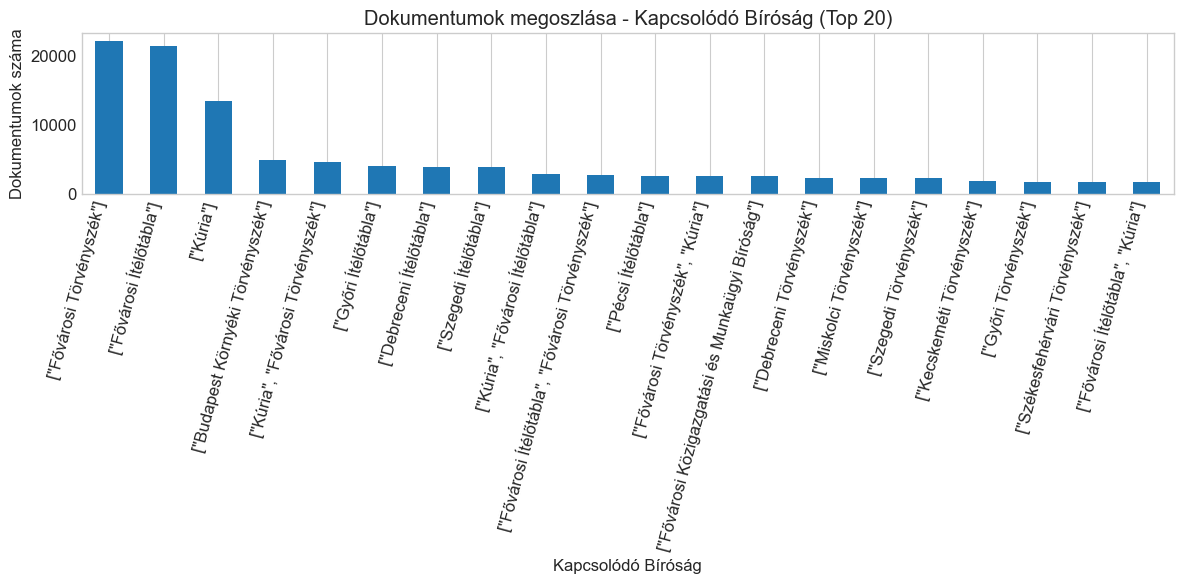


'Kapcsolódó Ügyszám' elemzése:
  Dokumentumok száma első kapcsolódó ügyszámmal: 176998
  Dokumentumok száma első kapcsolódó ügyszám nélkül: 39589

'Kapcsolódó Ügyszám' egyedi értékeinek száma: 4
Leggyakoribb 20 érték:


Kapcsolódó Ügyszám
["Bf.100/2011/4"]      4
["Pf.20966/2009/4"]    4
["Pf.20427/2007/4"]    4
["Pf.21358/2010/3"]    4
["Pf.20223/2007/4"]    3
["Pf.20306/2010/5"]    3
["Pf.20019/2024/4"]    3
["Pf.20750/2009/5"]    3
["Pf.20009/2024/4"]    3
["Pf.20721/2010/4"]    3
["Pf.20340/2010/4"]    3
["Pf.20029/2018/6"]    3
["Pf.20119/2011/4"]    3
["Pf.20777/2010/3"]    3
["Pf.20125/2018/4"]    3
["Bf.44/2023/7"]       3
["Pf.20242/2007/3"]    3
["Pf.20563/2011/4"]    3
["Pf.20076/2017/4"]    3
["Pf.20152/2018/4"]    3
Name: count, dtype: int64

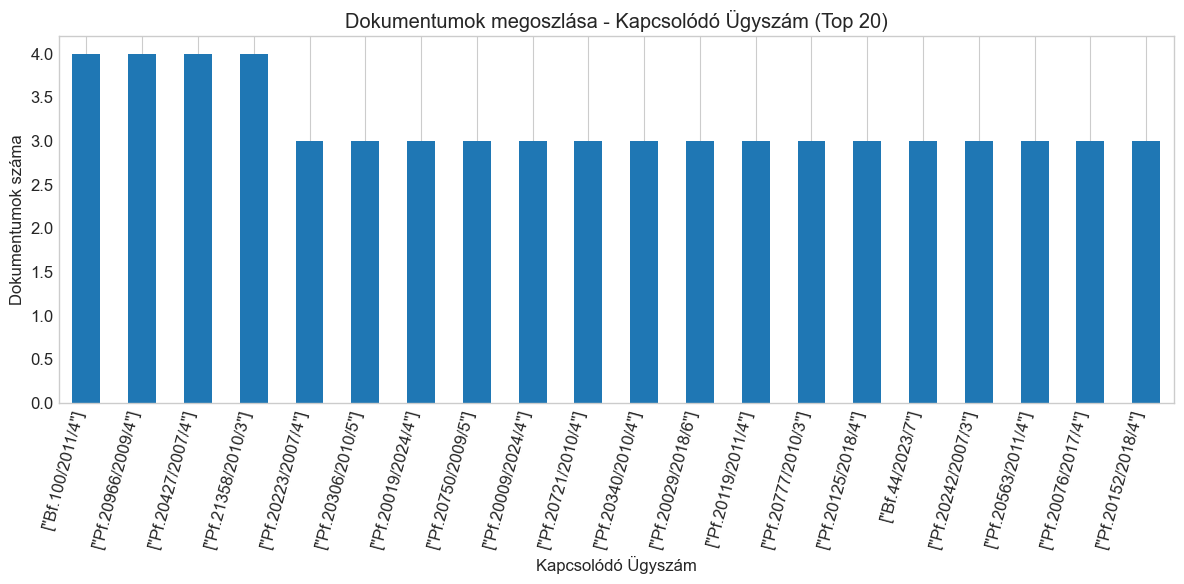

In [11]:
if 'df' in locals():
    # KapcsolodoHatarozatok (JSON stringként tárolva)
    if 'KapcsolodoHatarozatok' in df.columns:
        print("\n'KapcsolodoHatarozatok' elemzése:")
        # Számoljuk, hány rekordnak van nem-üres/nem-null kapcs. hat. listája
        # Feltételezzük, hogy a preprocess script NaN-t, '[]'-t vagy más stringet/listát menthet
        # Ez a sor ellenőrzi, hogy az érték nem NaN ÉS nem az üres lista string reprezentációja
        has_related = df['KapcsolodoHatarozatok'].notna() & (df['KapcsolodoHatarozatok'] != '[]')
        print(f"  Dokumentumok száma kapcsolódó határozattal (nem üres lista/nem NaN): {has_related.sum()}")
        print(f"  Dokumentumok száma kapcsolódó határozat nélkül (NaN vagy '[]'): {len(df) - has_related.sum()}")
    else:
        print("\n'KapcsolodoHatarozatok' oszlop nem található.")

    # Első kapcsolódó bíróság elemzése
    if 'Kapcsolódó Bíróság' in df.columns:
        plot_top_categories(df, 'Kapcsolódó Bíróság', top_n=20)
    else:
        print("\n'Kapcsolódó Bíróság' oszlop nem található.")

    # Első kapcsolódó ügyszám elemzése
    if 'Kapcsolódó Ügyszám' in df.columns:
        print("\n'Kapcsolódó Ügyszám' elemzése:")
        # Először csak a jelenlétét nézzük
        has_all_ugyszam = df['Kapcsolódó Ügyszám'].notna().sum()
        print(f"  Dokumentumok száma első kapcsolódó ügyszámmal: {has_all_ugyszam}")
        print(f"  Dokumentumok száma első kapcsolódó ügyszám nélkül: {len(df) - has_all_ugyszam}")
        # Most vizualizáljuk a leggyakoribb ügyszámokat
        plot_top_categories(df, 'Kapcsolódó Ügyszám', top_n=20)
    else:
        print("\n'Kapcsolódó Ügyszám' oszlop nem található.")

## 7.1. Jogszabályhelyek Mélyebb Elemzése


'Jogszabalyhelyek' elemzése:

Diagnosztika: Első 10 nem-üres/nem-'[]' Jogszabalyhelyek érték:
  1: Type=<class 'str'>, Value='1952. évi III. törvény a polgári perrendtartásról 78. § - 2010-09-23;</br>1952. évi III. törvény a polgári perrendtartásról 141. § - 2010-09-23;</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 278. § - 2009-07-17;</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 301. § - 2009-08-21;</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 365. § - 2009-07-17;</br>32/2003. (VIII. 22.) IM rendelet a bírósági eljárásban megállapítható ügyvédi költségekről 32. § - 2010-09-23;</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 365. § (1);</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 301/A. § (2);</br>1959. évi IV. törvény a Magyar Köztársaság Polgári Törvénykönyvéről 278. § (4);</br>1952. évi III. törvény a polgári perrendtartásról 78. § (1);</br>1952. évi I

parsed_jogszabalyhelyek
1952. évi III. törvény a polgári perrendtartásról 78. § (1);                                            87880
32/2003. (VIII. 22.) IM rendelet a bírósági eljárásban megállapítható ügyvédi költségekről 3. § (2);    42851
1952. évi III. törvény a polgári perrendtartásról 253. § (2);                                           40881
6/1986. (VI. 26.) IM rendelet a költségmentesség alkalmazásáról a bírósági eljárásban 13. § (2);        39083
32/2003. (VIII. 22.) IM rendelet a bírósági eljárásban megállapítható ügyvédi költségekről 3. § (5);    32514
6/1986. (VI. 26.) IM rendelet a költségmentesség alkalmazásáról a bírósági eljárásban 14. §;            27775
1952. évi III. törvény a polgári perrendtartásról 164. § (1);                                           27490
1952. évi III. törvény a polgári perrendtartásról 206. § (1);                                           27052
1952. évi III. törvény a polgári perrendtartásról 275. § (3);                                   

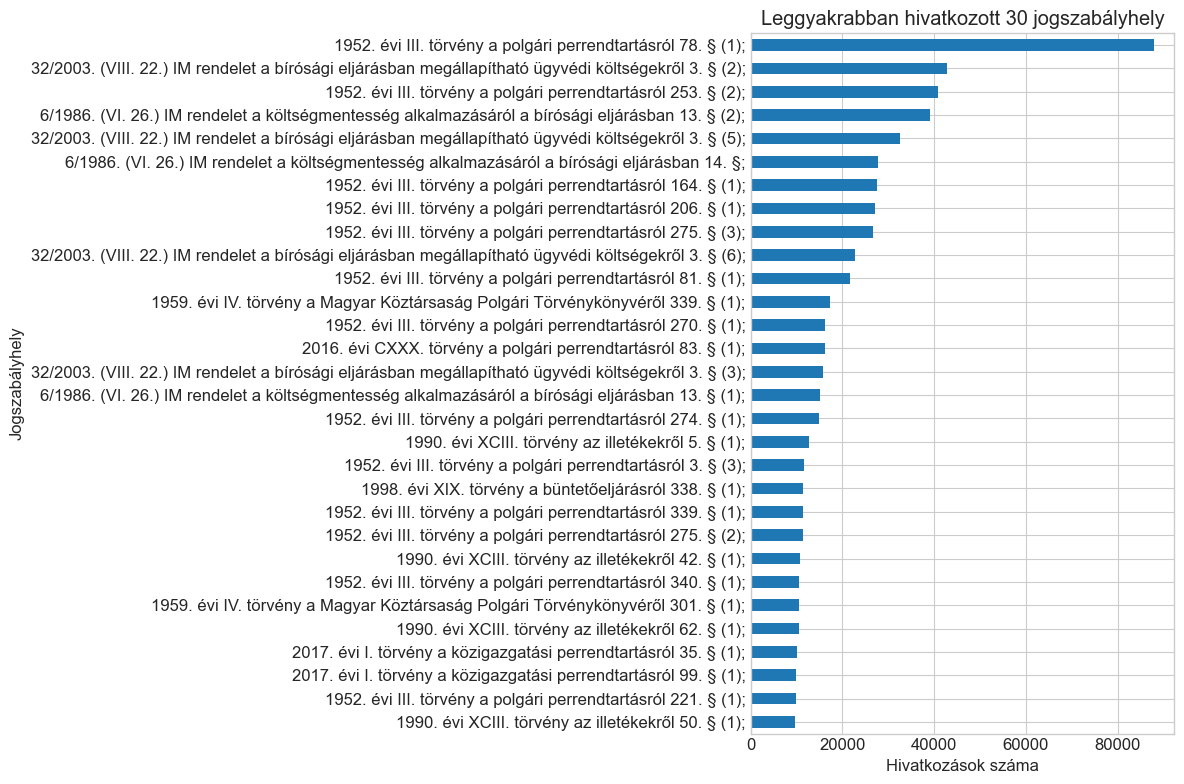

In [12]:
import ast
if 'df' in locals() and 'Jogszabalyhelyek' in df.columns:
    print("\n'Jogszabalyhelyek' elemzése:")

    # --- DIAGNOSZTICA START ---
    print("\nDiagnosztika: Első 10 nem-üres/nem-'[]' Jogszabalyhelyek érték:")
    sample_values = df[df['Jogszabalyhelyek'].notna() & (df['Jogszabalyhelyek'] != '[]')]['Jogszabalyhelyek'].head(10)
    if not sample_values.empty:
        for i, val in enumerate(sample_values):
            print(f"  {i+1}: Type={type(val)}, Value='{val}'")
    else:
        print("  Nem található minta a diagnosztikához (minden érték NaN vagy '[]').")
    print("--- DIAGNOSZTICA END ---\n")
    # --- END DIAGNOSTICS ---

    def parse_jogszabaly(value):
        if pd.isna(value) or not isinstance(value, str) or value.strip() == '[]' or not value.strip():
            return []
        try:
            # Darabolás a '</br>' mentén, majd felesleges szóközök eltávolítása
            items = value.split('</br>')
            # Üres elemek kiszűrése és szóközök eltávolítása az elemek elejéről/végéről
            cleaned_items = [item.strip() for item in items if item.strip()]
            return cleaned_items
        except Exception as e:
            # Váratlan hiba esetén is üres listát adunk vissza
            print(f"Hiba a jogszabályhely feldolgozása közben: {e}, Érték: {value}")
            return []

    df['parsed_jogszabalyhelyek'] = df['Jogszabalyhelyek'].apply(parse_jogszabaly)
    jogszabaly_series = df['parsed_jogszabalyhelyek'].explode().dropna()
    print(f"\nÖsszesen {len(jogszabaly_series)} jogszabályhely hivatkozás található (az összes dokumentumban).")
    if not jogszabaly_series.empty:
        jogszabaly_counts = jogszabaly_series.value_counts()
        print(f"\nEgyedi jogszabályhelyek száma: {len(jogszabaly_counts)}")
        top_n = 30
        print(f"\nLeggyakrabban hivatkozott {top_n} jogszabályhely:")
        display(jogszabaly_counts.head(top_n))
        plt.figure(figsize=(12, 8))
        jogszabaly_counts.head(top_n).plot(kind='barh')
        plt.title(f'Leggyakrabban hivatkozott {top_n} jogszabályhely')
        plt.xlabel('Hivatkozások száma')
        plt.ylabel('Jogszabályhely')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Nem található érvényes jogszabályhely hivatkozás az elemzéshez.")